In [1]:
import numpy as np 
import pandas as pd
import scipy


import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg

import seaborn as sns

# to render plots with white background
import seaborn as sns
sns.set_style('white')
# sns.set_context('notebook', font_scale=1.75)


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42



In [2]:
%%time
# These are the loaded dataframes that are calculated below

df_corr_all = pd.read_csv("data/int_pc_qvals_gcamp_dms.csv", index_col = 0) # .dropna(subset=['Q_dir_diff'])
# should add this to my actual original df_corr_all
# this just has unique MouseID's across recording sites. 
recordloc = np.array([0 if x == "DMS" else 1 for x in df_corr_all['RecordLoc']])
df_corr_all['MouseID_unique'] = df_corr_all['MouseID'] + recordloc * 12 





# update the gcamp values from strings --> arrays of floats 
df_src = df_corr_all

df_src['g_np'] = df_src['g_np'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_lp'] = df_src['g_lp'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_choice'] = df_src['g_choice'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))
df_src['g_reward'] = df_src['g_reward'].apply(
                        lambda line: np.array([float(val) for val in line[1:-1].replace('\n', '').split(' ') if val]))



CPU times: user 1.3 s, sys: 68.2 ms, total: 1.36 s
Wall time: 1.55 s


In [4]:
# some additional constants 

# for gcamp (dt = dt of gcamp recordings)
dt = 15
LEN_BEFORE = dt
LEN_AFTER = dt * 2
GCAMP_RANGE = np.arange(-1, 2, 1/dt)


In [5]:
df_corr_DMS = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'DMS'])
df_corr_DMS_CB = pd.DataFrame(df_corr_all[df_corr_all['RecordLoc'] == 'DMS_CB'])

# PLOTTING CONSTANTS

SZ_L = 15
SZ = 8
SZ_S = 6

# Actual Code

In [ ]:
print("df_corr_all is the pandas with terminals + cell-bodies data.")
print("df_DMS: only terminals")
print("df_DMS_CB: only cell-bodies")

In [6]:
df_corr_all['HighProb_num'] = df_corr_all['HighProb'].replace({'Ips':1, 'Con':0})
df_corr_all['Reversal'] = df_corr_all.groupby([df_corr_all['MouseID'], df_corr_all['Session'], 
                                                   df_corr_all['RecordLoc']])['HighProb_num'].diff().fillna(0)
# changedblock = 0 if no change;  1 or -1 denotes if it's contra -> ipsi OR ispi -> contra
# nan originally meant -> new block/session. I've set it to 0 (since this is REVERSALS we're talkinga bout. )



Trials_with_Switch = np.array(np.where(abs(df_corr_all['Reversal']) == 1))[0]
Switch_type = df_corr_all[abs(df_corr_all['Reversal']) == 1]['Reversal'].values

df_corr_all['TrialsAfterSwitch'] = np.nan
df_corr_all['TrialsBeforeSwitch'] = np.nan

df_corr_all.loc[Trials_with_Switch]['TrialsAfterSwitch'] = 0
df_corr_all.loc[Trials_with_Switch]['TrialsBeforeSwitch'] = 0

# at this point, you should have 
# ChangedBlock: 0 for no new block in this trial; 1 if there is a new block (in other words, indicator variable for changed block)
# TrialsAfter/BeforeSwitch: 0...10 for trials after/before the switch



In [7]:
# this is setting trials before/after switch properly 
for i in np.flip(np.arange(11), 0):
    forward = np.array([min(trial,len(df_corr_all) - 1) for trial in Trials_with_Switch + i])
    backward = np.array([max(trial,0) for trial in Trials_with_Switch - i])
    df_corr_all.loc[forward, 'TrialsAfterSwitch'] = np.round(i)
    df_corr_all.loc[backward,'TrialsBeforeSwitch'] = np.round(i)


In [9]:

prob_prev = np.zeros((2,21))
prob_prev_std = np.zeros((2, 21))

num_recording_sites = len(np.unique(df_corr_all['MouseID_unique']))


# for trials -10, +10 from block switch 
for t_i in np.arange(-10, 11):
    if t_i < 0:
        trials_i = df_corr_all[df_corr_all['TrialsBeforeSwitch'] == -t_i]
    else:
        trials_i = df_corr_all[df_corr_all['TrialsAfterSwitch'] == t_i]

    for i, [switch_type_i, switch_prev, switch_after] in enumerate(zip([-1, 1], ['Ips', 'Con'], ['Con', 'Ips'])):
        if (len(trials_i) == len(Switch_type) - 1):
            actions = trials_i[Switch_type[:-1] == switch_type_i].groupby('Action')['MouseID_unique'].value_counts()
        else:
            actions = trials_i[Switch_type == switch_type_i].groupby('Action')['MouseID_unique'].value_counts()
        
        prev_count = actions[switch_prev].sort_index().reindex(np.arange(num_recording_sites), fill_value=0)
        after_count = actions[switch_after].sort_index().reindex(np.arange(num_recording_sites), fill_value=0)

        prob = prev_count / (prev_count + after_count)
        
        prob_prev[i, t_i + 10] = prob.mean()
        prob_prev_std[i, t_i + 10] = prob.std()

prob_prev_sem = prob_prev_std / np.sqrt(len(np.unique(df_corr_all['MouseID_unique'])))

In [12]:
prob_prev
print("First row is ips->con switches")
print("second row is con->ips switches")

array([[0.71423077, 0.6821811 , 0.69196488, 0.6974153 , 0.75342837,
        0.73844324, 0.72846452, 0.72019887, 0.81578427, 0.84170252,
        0.77633789, 0.70007508, 0.55174716, 0.40413118, 0.41229605,
        0.32045538, 0.30569232, 0.26484475, 0.26132589, 0.24790267,
        0.23315097],
       [0.72257571, 0.773229  , 0.82604352, 0.81256813, 0.79627855,
        0.79035768, 0.82769603, 0.84874418, 0.8464366 , 0.90049508,
        0.83574191, 0.76202189, 0.58856034, 0.54291925, 0.46352244,
        0.41635696, 0.39022177, 0.33693168, 0.39441955, 0.3708359 ,
        0.30802617]])

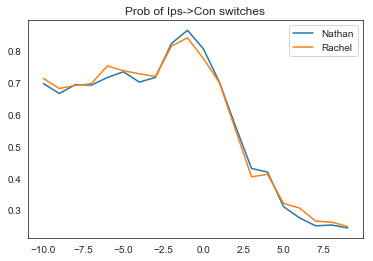

In [29]:
nathan_ips_con = np.array([0.677772529708960,    0.698081548225467 ,   0.666434660030906 ,   0.694352022188414 ,   0.692972844738602 ,   0.716832546856411  ,  0.734943889192130  ,  0.702393421183573 ,   0.717172857039767   , 0.823730421467626   , 0.865700146168827 ,   0.806793437344511    ,0.701525240327009    ,0.563628605889851 ,   0.430423366776213    ,0.419238232558338 ,   0.310126504118761 ,   0.274841517330203    ,0.249851720948033 ,   0.252367115005606  ,  0.243308501986484])
plt.plot(np.arange(-10, 10), nathan_ips_con[1:], label = "Nathan")
plt.plot(np.arange(-10, 10), prob_prev[0,:-1], label = "Rachel")
plt.title("Prob of Ips->Con switches")
plt.legend()

In [36]:
np.mean(prob_prev[0,:-1] - nathan_ips_con[1:])

0.003195181655815893

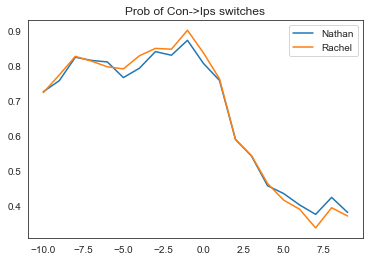

In [34]:
nathan_con_ips = np.array([0.678742327503937,    0.725201657647478,    0.756837929871986,    0.823564464431338,    0.814517158108489 ,   0.810130608985098 ,   0.765555397474902,    0.792203974216358  ,  0.839537466317652  ,  0.829236319236319 ,   0.871756929001511   , 0.805791016688850   , 0.757488624206890  ,  0.589139701028246    ,0.541719680388411    ,0.457260520697053   , 0.434965134624577 ,   0.402521723202838    ,0.375491611931240   , 0.423961731423032  ,  0.380972082612949])
plt.plot(np.arange(-10,10), nathan_con_ips[1:], label = "Nathan")
plt.plot(np.arange(-10,10), prob_prev[1,:-1], label = "Rachel")
plt.title("Prob of Con->Ips switches")
plt.legend()


In [37]:
np.mean(prob_prev[1,:-1] - nathan_con_ips[1:])

0.002405123188183436

RESPONSE FIGURE: IPS TO CON REVERSALS


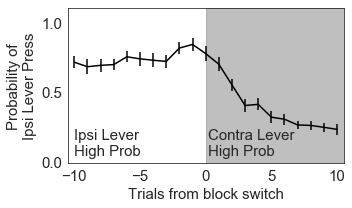

In [10]:
print("RESPONSE FIGURE: IPS TO CON REVERSALS")
figure = plt.figure(figsize=(5, 3))
ax = plt.gca()
ax.errorbar(np.arange(-10, 11), prob_prev[0,:], yerr = prob_prev_sem[0, :], color = 'k')
ax.set_xlabel('Trials from block switch', size = SZ_L)
ax.set_ylabel('Probability of\nIpsi Lever Press', size = SZ_L )
ax.axvspan(0, 11, color = 'grey', alpha = 0.5)
ax.set_xlim([-10.5, 10.5])
ax.set_ylim([-0.01, 1.1])
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([0, 0.5, 1.0])
ax.text(0.15, 0.05, 'Contra Lever\nHigh Prob', size = SZ_L)
ax.text(-10, 0.05, 'Ipsi Lever\nHigh Prob', size = SZ_L)
ax.tick_params(labelsize = SZ_L, length = 2)

plt.tight_layout()
# plt.savefig('figs/FigR9a.pdf', transparent=True)



RESPONSE FIGURE: CON TO IPS REVERSALS


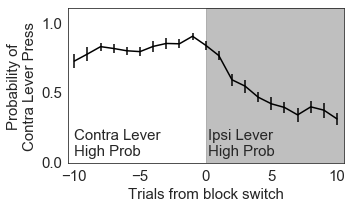

In [11]:
print("RESPONSE FIGURE: CON TO IPS REVERSALS")


figure = plt.figure(figsize=(5, 3))
ax = plt.gca()
ax.errorbar(np.arange(-10, 11), prob_prev[1,:], yerr = prob_prev_sem[1, :], color = 'k')
ax.set_xlabel('Trials from block switch', size = SZ_L)
ax.set_ylabel('Probability of\nContra Lever Press', size = SZ_L )
ax.axvspan(0, 11, color = 'grey', alpha = 0.5)
ax.set_xlim([-10.5, 10.5])
ax.set_ylim([-0.01, 1.1])
ax.set_xticks([-10, -5, 0, 5, 10])
ax.set_yticks([0, 0.5, 1.0])
ax.text(0.15, 0.05, 'Ipsi Lever\nHigh Prob', size = SZ_L)
ax.text(-10, 0.05, 'Contra Lever\nHigh Prob', size = SZ_L)
ax.tick_params(labelsize = SZ_L, length = 2)

plt.tight_layout()
plt.savefig('figs/FigR9b.pdf', transparent=True)


        